## Part 1: Crime Dataset

#### Load, Explore and Clean 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
newyork = pd.read_csv("../../../Data & Script/newyork_offence.csv", skiprows=5, skipfooter=3, thousands=",", 
                      names=['city', 'population', 'violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape1', 'rape2', 'robbery', 
                             'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft', 'motor_vehicle_theft', 'arson3'], engine='python')
import warnings
warnings.filterwarnings("ignore")
print(len(newyork))
newyork.tail()

348


,city,population,violent_crime,murder_and_nonnegligent_manslaughter,rape1,rape2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,motor_vehicle_theft,arson3
343,Woodbury Town,10685,3,0,NaN,0,2,1,541,9,529,3,NaN
344,Woodridge Village,829,7,0,NaN,0,0,7,17,8,9,0,0.0
345,Woodstock Town,5931,2,0,NaN,0,0,2,58,13,45,0,NaN
346,Yonkers,199134,1036,6,NaN,25,390,615,2368,470,1662,236,10.0
347,Yorktown Town,36643,15,0,NaN,0,2,13,334,45,287,2,NaN


In [2]:
# see null values in all columns
#print(newyork.isna().sum())
# dropping column 4 and 12 because they contain a lot of null values
newyork = newyork.drop(newyork.columns[4], axis=1)
newyork = newyork.drop(newyork.columns[-1], axis=1)
# drop a cell which contains atleast one missing values, 
newyork = newyork.dropna().reset_index(drop=True)

In [3]:
# replace outlier with the mean
# iteration determines how many times you want to run the replacement
def replace_outliers_with_mean(datax, column, iteration):
    replaced_numbers = set()
    for i in range(iteration):
        outliers = np.where(np.abs(stats.zscore(datax[column])) >= 3)
        non_outliers = np.where(np.abs(stats.zscore(datax[column])) < 3)
        the_mean = np.mean(non_outliers)
        if(len(outliers[0]) > 0):
            replaced_numbers.update(outliers[0])
            # for each outlier in outliers list
            for o in outliers:
                datax.loc[o,column] = the_mean
    return replaced_numbers

In [4]:
# replace outliers in all collumns with the mean of the column
for col in newyork.columns[1:]:
    # print which rows are replaced
    replaced_numbers = replace_outliers_with_mean(newyork, col,1)
    print("{} {}".format(col.replace("\n", " "), replaced_numbers))

population {216}
violent_crime {216}
murder_and_nonnegligent_manslaughter {216}
rape2 {216}
robbery {216}
aggravated_assault {216}
property_crime {216}
burglary {216, 35}
larceny_theft {216}
motor_vehicle_theft {216}


#### Feature Selection

In [5]:
#create the features
newyork['pop_squared'] = newyork['population'] ** 2
newyork['murder_cat'] = newyork['murder_and_nonnegligent_manslaughter'] > 0
newyork['robbery_cat'] = newyork['robbery'] > 0

In [6]:
# divide property crime into 5 bins. All bins contain the same amount of data
newyork['property_crime_cat'] = pd.qcut(newyork['property_crime'], 10 , labels=range(10))

In [7]:
newyork[['property_crime', 'property_crime_cat']].head()

,property_crime,property_crime_cat
0,12.0,0
1,24.0,1
2,16.0,1
3,4090.0,9
4,223.0,6


In [8]:
X = newyork[['population', 'violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape2', 'robbery', 
                             'aggravated_assault', 'burglary', 'larceny_theft', 'motor_vehicle_theft']]
y = newyork.property_crime_cat

##### Univarite Methods

There are some drawbacks of using F-Test to select your features. F-Test checks for and only captures linear relationships between features and labels. 
A highly correlated feature is given higher score and less correlated features are given lower score. Correlation is highly deceptive as it doesn’t capture strong non-linear relationships.

Advantage of using mutual information over F-Test is,  it does well with the non-linear relationship between feature and target variable.

In [9]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

In [10]:
selector_one = SelectKBest(f_classif , k=3)
selector_one.fit(X, y)
print(X.columns[selector_one.get_support(indices=True)])

Index(['population', 'burglary', 'larceny_theft'], dtype='object')


In [11]:
selector_two = SelectKBest(mutual_info_classif, k=3)
selector_two.fit(X, y)
print(X.columns[selector_two.get_support(indices=True)])

Index(['violent_crime', 'burglary', 'larceny_theft'], dtype='object')


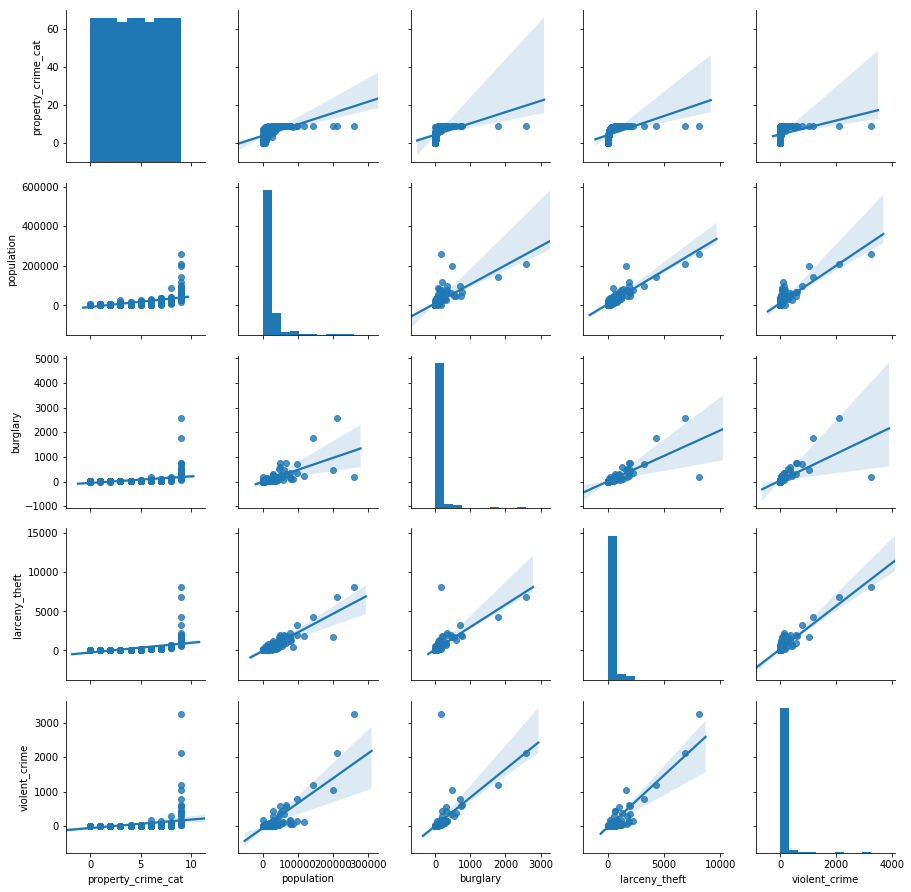

In [12]:
#Check linear relationship
sns.pairplot(newyork[['property_crime_cat', 'population', 'burglary', 'larceny_theft', 'violent_crime' ]], kind='reg')

##### Other Methods: Recursive feature elimination

Index(['burglary', 'larceny_theft', 'motor_vehicle_theft'], dtype='object')
Optimal number of features : 3
Index(['burglary', 'larceny_theft', 'motor_vehicle_theft'], dtype='object')
score:  0.9971264367816092


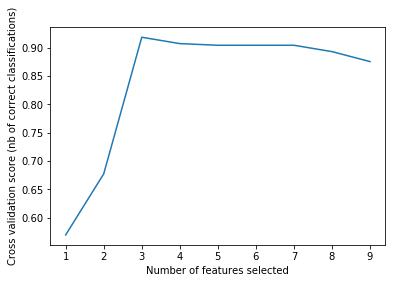

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV 
# The "accuracy" scoring is proportional to the number of correct classifications
selector_three = RFECV(estimator= SVC(kernel="linear"), step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
selector_three.fit(X, y)
print(X.columns[selector_three.get_support(indices=True)])

print("Optimal number of features : %d" % selector_three.n_features_)
print(X.columns[selector_three.get_support(indices=True)])
print("score: ", selector_three.score(X, y))
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector_three.grid_scores_) + 1), selector_three.grid_scores_)
plt.show()

Optimal number of features : 4
Index(['population', 'violent_crime', 'burglary', 'larceny_theft'], dtype='object')
0.9971264367816092


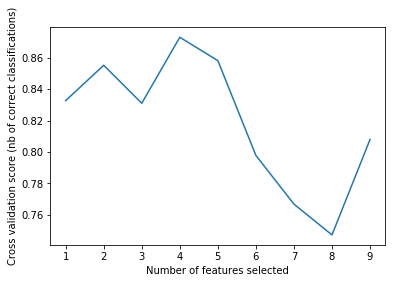

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
# The "accuracy" scoring is proportional to the number of correct
# classifications
selector_four = RFECV(RandomForestClassifier(), scoring='accuracy')
selector_four.fit(X, y)
print("Optimal number of features : %d" % selector_four.n_features_)
print(X.columns[selector_four.get_support(indices=True)])
print(selector_four.score(X,y))
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector_four.grid_scores_) + 1), selector_four.grid_scores_)
plt.show()

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True)

### Sklearn Logistic Regression

multi_class : str, {‘ovr’, ‘multinomial’, ‘auto’}, default: ‘ovr’
If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.


solver : str, {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default: ‘liblinear’.
Algorithm to use in the optimization problem.

For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.

##### Vanilla logistic regression

C : float, default: 1.0
Inverse of regularization strength; must be a positive float. 
Like in support vector machines, smaller values specify stronger regularization.

In [16]:
from sklearn.linear_model import LogisticRegression
X_train_t = selector_two.transform(X_train)
X_test_t = selector_two.transform(X_test)
# no regularization(becasue the inverse regularization is big)
modelA = LogisticRegression(C=1e20, solver='newton-cg', multi_class='multinomial')
modelA.fit(X_train_t, y_train)

# Display.
print('Coefficients')
print(modelA.coef_)
print(modelA.intercept_)
yhat = modelA.predict(X_train_t)

print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelA.score(X_train_t, y_train))
print("testing: ", modelA.score(X_test_t, y_test))

Coefficients
[[  1.30910023 -11.34149496 -10.7241811 ]
 [ -0.95605867  -4.76830467  -4.52366972]
 [ -0.8483004   -1.39188493  -1.29984385]
 [ -0.01839922   0.17344379   0.49647142]
 [ -0.18118301   1.66066667   1.648392  ]
 [  0.12128569   2.43266617   2.23780581]
 [  0.22242733   2.87402178   2.79030066]
 [  0.25779623   3.2101299    2.9483072 ]
 [  0.04703221   3.48163827   3.16289228]
 [  0.04632506   3.66917898   3.2640013 ]]
[ 388.08010802  303.32091694  202.31422761  113.66802291   25.46567857
  -46.25241522 -139.38786247 -190.29393404 -279.38596437 -377.52877745]

 Accuracy
Predicted   0   1   2   3   4   5   6   7   8   9
True                                             
0          31   0   0   0   0   0   0   0   0   0
1           0  28   1   0   0   0   0   0   0   0
2           0   1  28   0   0   0   0   0   0   0
3           0   0   0  28   0   0   0   0   0   0
4           0   0   0   0  26   1   0   0   0   0
5           0   0   0   0   1  24   0   0   0   0
6           

* Without regularization, newton achived maximum possible performance
* At first I was using only 5 categories for property_crime and the performance of Vanilla logistic regression became one on both train and test sets. The model will be more useful with more categories, thus I incresed the categories to 10.


#### Ridge logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression
X_train_t = selector_two.transform(X_train)
X_test_t = selector_two.transform(X_test)
# 
modelB = LogisticRegression(penalty='l2', solver='newton-cg', C=1, multi_class='multinomial')
modelB.fit(X_train_t, y_train)

# Display.
print('Coefficients')
print(modelB.coef_)
print(modelB.intercept_)
yhat = modelB.predict(X_train_t)

print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelB.score(X_train_t, y_train))
print("testing: ", modelB.score(X_test_t, y_test))

Coefficients
[[-0.17381806 -2.13428731 -2.21236101]
 [-0.35879518 -1.09325315 -1.31889697]
 [-0.13366572 -0.61227006 -0.73795425]
 [ 0.02632275 -0.21266151 -0.20295706]
 [ 0.0325985   0.10760207  0.16621228]
 [ 0.1080901   0.35834526  0.44684896]
 [ 0.17797019  0.57832149  0.7439411 ]
 [ 0.21163354  0.8186169   0.87704721]
 [ 0.05121293  1.01558545  1.06372141]
 [ 0.05844127  1.17386488  1.17422499]]
[ 132.20329776  119.77802776  102.41802028   76.82097483   50.27485422
   18.59820953  -31.0631693   -72.29165294 -147.85667864 -248.8818835 ]

 Accuracy
Predicted   0   1   2   3   4   5   6   7   8   9
True                                             
0          31   0   0   0   0   0   0   0   0   0
1           0  27   2   0   0   0   0   0   0   0
2           0   0  29   0   0   0   0   0   0   0
3           0   0   0  28   0   0   0   0   0   0
4           0   0   0   0  27   0   0   0   0   0
5           0   0   0   0   1  24   0   0   0   0
6           0   0   0   0   0   0  27   0 

- multinomial with newton-cg performed very well, and it is better on the test set than vanilla logistic regression
- The default penality performs better on the test-set

#### Lasso logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression
X_train_t = selector_two.transform(X_train)
X_test_t = selector_two.transform(X_test)

modelC = LogisticRegression(penalty='l1', solver='liblinear', C=1, multi_class='ovr')
modelC.fit(X_train_t, y_train)

# Display.
print('Coefficients')
print(modelC.coef_)
print(modelC.intercept_)
yhat = modelC.predict(X_train_t)

print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelC.score(X_train_t, y_train))
print("testing: ", modelC.score(X_test_t, y_test))

Coefficients
[[ 4.22312984e-02 -6.77008701e-01 -4.11528210e-01]
 [-7.37777261e-02  5.37694260e-02 -6.07786747e-02]
 [-8.68266118e-03 -1.01683960e-02 -1.76243278e-02]
 [-4.04068963e-02  1.39245518e-02 -9.47396694e-03]
 [-9.10598360e-03  3.52878043e-03 -4.38602716e-03]
 [-1.18599356e-02  1.54453112e-02 -4.12831376e-03]
 [-2.39676382e-03 -7.91578814e-03  8.44184674e-04]
 [-6.31981005e-03  2.57713559e-03  6.15154576e-04]
 [-8.68055069e-03 -3.18931589e-04  2.66195114e-03]
 [ 1.15539056e-03  1.97320395e-02  7.95342579e-03]]
[ 6.07753724  0.         -0.76262209 -1.24545945 -1.61384874 -1.93322103
 -2.01636912 -2.3684332  -2.61820047 -8.51659567]

 Accuracy
Predicted   0   1   2   3   4  5   6  7   8   9
True                                           
0          31   0   0   0   0  0   0  0   0   0
1           3  21   5   0   0  0   0  0   0   0
2           0   6  22   1   0  0   0  0   0   0
3           0   0  11  17   0  0   0  0   0   0
4           0   0   0  11  13  0   3  0   0   0
5     

* Saga and liblinear are the only solvers which support l1 regularization. liblinear is good for small datasets than Saga.
* liblinear performed better.

#### Finding the best penality for Ridge

In [19]:
from sklearn.model_selection import GridSearchCV

# prepare a range of alpha values to test
# Remember that C cannot be 0
inverse_regs = np.array([1e4, 1e3, 1e2, 1e1, 1,1e-1, 1e-2,1e-3,1e4])
#alphas = np.logspace(-5,9,20)

# create and fit a ridge logistic regression model, testing each C
grid = GridSearchCV(estimator=LogisticRegression(penalty='l2', solver='newton-cg', multi_class='multinomial'), param_grid=dict(C=inverse_regs), scoring='accuracy')
grid.fit(X_train_t, y_train)
print(grid)
# summarize the results of the grid search
print("Best CV score for Ridge: ", grid.best_score_)
print("Best C for Ridge: ", grid.best_estimator_.C)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e+04, 1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03,
       1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)
Best CV score for Ridge:  0.9100719424460432
Best C for Ridge:  0.1


#### Using Logistic Regression CV

For a multiclass problem, the hyperparameters for each class are computed using the best scores got by doing a one-vs-rest in parallel across all folds and classes. Hence this is not the true multinomial loss.

In [20]:
from sklearn.linear_model import LogisticRegressionCV
modelD = LogisticRegressionCV(cv=10, random_state=20, solver='newton-cg', multi_class='multinomial').fit(X_train_t, y_train)
# Display.
print('Coefficients')
print(modelD.coef_)
print(modelD.intercept_)
yhat = modelD.predict(X_train_t)

print("What inverse regularization? ", modelD.C_)
print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelD.score(X_train_t, y_train))
print("testing: ", modelD.score(X_test_t, y_test))

Coefficients
[[-0.2298037  -3.06467179 -3.04393091]
 [-0.51162015 -1.63049748 -1.80073336]
 [-0.2108388  -0.91864431 -1.00770572]
 [ 0.05702126 -0.31427106 -0.2652777 ]
 [ 0.03692749  0.17647406  0.23024026]
 [ 0.15198079  0.55696517  0.60192114]
 [ 0.25421549  0.88840404  1.04157848]
 [ 0.29904877  1.1865544   1.20195159]
 [ 0.07027278  1.46342111  1.44732235]
 [ 0.08279615  1.65626584  1.59463394]]
[ 181.03501832  163.77738502  139.5839825   103.53902363   67.26180697
   24.47368248  -49.25176616  -99.41690894 -199.34366368 -331.65856016]
What inverse regularization?  [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594
 2.7825594 2.7825594 2.7825594]

 Accuracy
Predicted   0   1   2   3   4   5   6   7   8   9
True                                             
0          31   0   0   0   0   0   0   0   0   0
1           0  27   2   0   0   0   0   0   0   0
2           0   1  28   0   0   0   0   0   0   0
3           0   0   0  28   0   0   0   0   0   0
4        

* This one is the best test-score so far
* It is not using true multinomial loss to select hyper parameters

##### Selector 3 increases the performance

In [21]:
from sklearn.linear_model import LogisticRegressionCV
X_train_t = selector_three.transform(X_train)
X_test_t = selector_three.transform(X_test)

modelZ = LogisticRegressionCV(cv=10, random_state=20, solver='newton-cg', multi_class='multinomial').fit(X_train_t, y_train)
# Display.
print('Coefficients')
print(modelZ.coef_)
print(modelZ.intercept_)
yhat = modelZ.predict(X_train_t)

print("What inverse regularization? ", modelD.C_)
print('\n Accuracy')
print(pd.crosstab(y_train, yhat, rownames=['True'], colnames=['Predicted']))

print('\n Percentage accuracy')
print("training: ", modelZ.score(X_train_t, y_train))
print("testing: ", modelZ.score(X_test_t, y_test))

Coefficients
[[-1.44962502 -1.64952353 -0.15951536]
 [-0.71996844 -1.00285784 -0.39671552]
 [-0.3827489  -0.58135451 -0.20433688]
 [-0.13756253 -0.18380732  0.10309334]
 [ 0.0675829   0.11121851 -0.11780795]
 [ 0.20859243  0.34093334  0.03388047]
 [ 0.38517039  0.55553343  0.25761915]
 [ 0.57816442  0.67005928  0.02669081]
 [ 0.66018121  0.82588247  0.20942767]
 [ 0.79021305  0.91391738  0.24766473]]
[ 100.55848456   91.54072298   79.306382     60.57721241   40.38120437
   15.73369513  -20.81421853  -53.80596158 -115.86596514 -197.6115562 ]
What inverse regularization?  [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594
 2.7825594 2.7825594 2.7825594]

 Accuracy
Predicted   0   1   2   3   4   5   6   7   8   9
True                                             
0          31   0   0   0   0   0   0   0   0   0
1           0  27   2   0   0   0   0   0   0   0
2           0   0  29   0   0   0   0   0   0   0
3           0   0   0  27   1   0   0   0   0   0
4        

In [22]:
texas = pd.read_csv("../../../Data & Script/texas_offence.csv", skiprows=5, skipfooter=3, thousands=",", 
                      names=['city', 'population', 'violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape1', 'rape2', 'robbery', 
                             'aggravated_assault', 'property_crime', 'burglary', 'larceny_theft', 'motor_vehicle_theft', 'arson3'], engine='python')

texas = texas.drop(texas.columns[4], axis=1)
texas = texas.drop(texas.columns[-1], axis=1)
texas = texas.dropna().reset_index(drop=True)

# replace outliers in all collumns with the mean of the column
for col in texas.columns[1:]:
    # print which rows are replaced
    replaced_numbers = replace_outliers_with_mean(texas, col,1)
    print("{} {}".format(col.replace("\n", " "), replaced_numbers))
                             
texas['pop_squared'] = texas['population'] ** 2
texas['murder_cat'] = texas['murder_and_nonnegligent_manslaughter'] > 0
texas['robbery_cat'] = texas['robbery'] > 0
texas['property_crime_cat'] = pd.qcut(texas['property_crime'], 10 , labels=range(10))

X_texas = texas[['population', 'violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape2', 'robbery', 
                             'aggravated_assault', 'burglary', 'larceny_theft', 'motor_vehicle_theft']]
y_texas = texas.property_crime_cat


population {11}
violent_crime {11}
murder_and_nonnegligent_manslaughter {11}
rape2 {11}
robbery {11}
aggravated_assault {11}
property_crime {11}
burglary {11}
larceny_theft {11}
motor_vehicle_theft {11}


In [23]:
import statsmodels.api as sm
X_sm = sm.add_constant(X_train_t)
model = sm.OLS(y_train,X_sm)
results = model.fit()
results.summary()
#print(ols_model.get_params)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     property_crime_cat   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     68.10
Date:                Sun, 30 Dec 2018   Prob (F-statistic):           6.21e-33
Time:                        18:36:11   Log-Likelihood:                -615.32
No. Observations:                 278   AIC:                             1239.
Df Residuals:                     274   BIC:                             1253.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2856      0.155     21.173      0.000       2.980       3.591
x1            -0.0019      0.001     -1.626      0.105      -0.004       0.000
x2             0.0066      0.001     11.202      0.000       0.005       0.008
x3            -0.0476      0.005     -9.416      0.000      -0.058      -0.038
==============================================================================
Omnibus:                        0.594   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.743   Jarque-Bera (JB):                0.348
Skew:                           0.022   Prob(JB):                        0.840
Kurtosis:                       3.167   Cond. No.                         932.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
import statsmodels.api as sm
sample_x = pd.DataFrame({"col1": [50,0,3,14,5,36,7], "col2:":[8,12,31,5,107,8,41]})
sample_y = sample_x.sum(axis=1)
model = sm.OLS(sample_y,sample_x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.400e+32
Date:                Sun, 30 Dec 2018   Prob (F-statistic):           1.46e-81
Time:                        18:36:11   Log-Likelihood:                 222.50
No. Observations:                   7   AIC:                            -441.0
Df Residuals:                       5   BIC:                            -441.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
col1           1.0000   7.21e-17   1.39e+16      0.000       1.000       1.000
col2:          1.0000   3.84e-17    2.6e+16      0.000       1.000       1.000
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.500
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.403
Skew:                           0.949   Prob(JB):                        0.496
Kurtosis:                       1.900   Cond. No.                         1.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""